# Notebook for plotting supplementary figure for significance

In [1]:
import warnings

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps as gvcmaps
import geocat.viz.util as gvutil
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

warnings.filterwarnings("ignore")

In [2]:
BASE = "/glade/work/malbright/final_nam_manuscript_files/significance/"
RES = "LR"  # options: "LR", "HR"

# convert to mm/day:
MS_TO_MM_DAY = 1000.0 * 86400.0

month_labels = ["JJAS", "JJ", "AS"]

# Levels and colormaps
levels_total = np.arange(0, 10, 1)  # mm/day
levels_diff = np.arange(-2.4, 2.5, 0.2)  # mm/day
cmap_total = gvcmaps.precip4_11lev
cmap_diff = gvcmaps.precip_diff_12lev

# lon/lat domain (lon is 0–360 in the files; 245–270E = 115–90W)
xlim = (-115, -90)
ylim = (10, 35)
xticks = np.arange(-115, -85, 10)
yticks = np.arange(10, 35, 10)

In [3]:
np.arange(10, 35, 10)

array([10, 20, 30])

In [4]:
def load_fields(label, res=RES):
    """
    Load Plio mean, PI mean, diff, and significance mask for a given month label.
    Returns:
      plio, pi, diff in mm/day, and sig_mask (1 = significant, 0 = not significant).
    """
    fpath = f"{BASE}/prect_plio_minus_pi_{res}_ttest_{label}.nc"
    ds = xr.open_dataset(fpath)

    plio = ds[f"prect_plio_mean_{label}"] * MS_TO_MM_DAY
    pi = ds[f"prect_pi_mean_{label}"] * MS_TO_MM_DAY
    diff = ds[f"prect_diff_{label}"] * MS_TO_MM_DAY
    sig = ds[f"sig_mask_{label}"]  # short, 0/1

    return plio, pi, diff, sig

In [5]:
def fix_lon(ds):
    """Convert lon from 0–360 to -180–180."""
    ds = ds.copy()
    if ds.lon.max() > 180:
        ds = ds.assign_coords(lon=((ds.lon + 180) % 360) - 180)
        ds = ds.sortby("lon")
    return ds


def add_not_sig_shading(
    ax,
    sig_da,
    xlim=(-115, -90),
    ylim=(10, 35),
    shade_color="0.1",
    alpha=0.3,
    zorder=5,
):
    """
    Shade NOT-significant (sig==0) regions using contourf on a binary mask.
    """
    sig_da = fix_lon(sig_da)

    # 1 = not significant, 0 = significant
    notsig = xr.where(sig_da == 0, 1.0, 0.0)

    ax.contourf(
        notsig.lon.values,
        notsig.lat.values,
        notsig.values,
        levels=[0.5, 1.5],          # fill only the "1" class
        colors=[shade_color],
        alpha=alpha,
        transform=ccrs.PlateCarree(),
        zorder=zorder,
    )

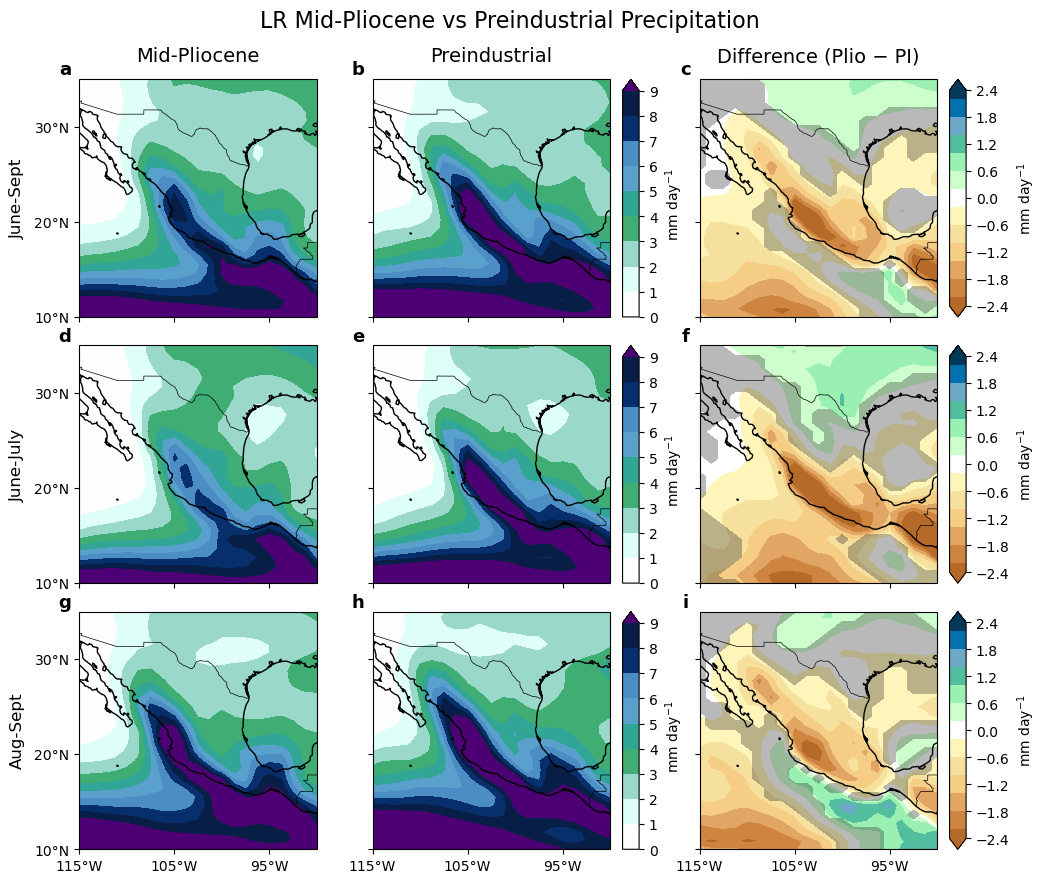

In [6]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 10))
grid = fig.add_gridspec(
    nrows=3,
    ncols=5,
    width_ratios=[1, 1, 0.06, 1, 0.06],  # Plio | PI | cbar | Diff | cbar
    wspace=0.10,
    hspace=0.12,
)

axes = []  # will hold 3×3 main plot axes: [row][0=Plio,1=PI,2=Diff]
cbar_axes_total = []  # one colorbar axis per row for Plio+PI
cbar_axes_diff = []  # one colorbar axis per row for Diff

for i in range(3):  # rows
    row_axes = []

    # Plio (col 0)
    ax_plio = fig.add_subplot(grid[i, 0], projection=proj)
    ax_plio.add_feature(cfeature.COASTLINE, zorder=4)
    ax_plio.add_feature(cfeature.BORDERS, linewidth=0.5)
    gvutil.set_axes_limits_and_ticks(
        ax_plio,
        xlim=xlim,
        ylim=ylim,
        xticks=xticks,
        yticks=yticks,
    )
    row_axes.append(ax_plio)

    # PI (col 1)
    ax_pi = fig.add_subplot(grid[i, 1], projection=proj)
    ax_pi.add_feature(cfeature.COASTLINE, zorder=4)
    ax_pi.add_feature(cfeature.BORDERS, linewidth=0.5)
    gvutil.set_axes_limits_and_ticks(
        ax_pi,
        xlim=xlim,
        ylim=ylim,
        xticks=xticks,
        yticks=yticks,
    )
    row_axes.append(ax_pi)

    # colorbar for Plio+PI (col 2)
    ax_cbar_total = fig.add_subplot(grid[i, 2])
    cbar_axes_total.append(ax_cbar_total)

    # Diff (col 3)
    ax_diff = fig.add_subplot(grid[i, 3], projection=proj)
    ax_diff.add_feature(cfeature.COASTLINE, zorder=4)
    ax_diff.add_feature(cfeature.BORDERS, linewidth=0.5)
    gvutil.set_axes_limits_and_ticks(
        ax_diff,
        xlim=xlim,
        ylim=ylim,
        xticks=xticks,
        yticks=yticks,
    )
    row_axes.append(ax_diff)

    # colorbar for Diff (col 4)
    ax_cbar_diff = fig.add_subplot(grid[i, 4])
    cbar_axes_diff.append(ax_cbar_diff)

    axes.append(row_axes)

# Row labels on left (JJAS, JJ, AS)
row_labels = ["June-Sept", "June-July", "Aug-Sept"]
for i, lab in enumerate(row_labels):
    axes[i][0].text(
        -0.26,
        0.5,
        lab,
        transform=axes[i][0].transAxes,
        rotation=90,
        va="center",
        ha="center",
        fontsize=12,
    )

total_handles = []
diff_handles = []

for i, label in enumerate(month_labels):
    ax_plio = axes[i][0]
    ax_pi = axes[i][1]
    ax_diff = axes[i][2]

    # Load data for this month combination
    plio, pi, diff, sig = load_fields(label, res=RES)

    # --- Total precip: Plio ---
    kwargs_total = dict(
        levels=levels_total,
        add_colorbar=False,
        transform=proj,
        xticks=[],
        yticks=[],
    )
    total_plio = plio.plot.contourf(
        ax=ax_plio,
        cmap=cmap_total,
        **kwargs_total,
    )
    gvutil.set_titles_and_labels(
        ax_plio,
        xlabel="",
        ylabel="",
        labelfontsize=11,
    )

    # --- Total precip: PI ---
    total_pi = pi.plot.contourf(
        ax=ax_pi,
        cmap=cmap_total,
        **kwargs_total,
    )
    gvutil.set_titles_and_labels(ax_pi, xlabel="", ylabel="")

    # Use PI handle for total colorbar for this row
    total_handles.append(total_pi)

    # --- Difference + stippling ---
    norm_diff = mcolors.TwoSlopeNorm(
        vmin=levels_diff[0],
        vcenter=0,
        vmax=levels_diff[-1],
    )
    kwargs_diff = dict(
        levels=levels_diff,
        add_colorbar=False,
        transform=proj,
        norm=norm_diff,
        xticks=[],
        yticks=[],
    )
    diff_plot = diff.plot.contourf(
        ax=ax_diff,
        cmap=cmap_diff,
        **kwargs_diff,
    )
    gvutil.set_titles_and_labels(ax_diff, xlabel="", ylabel="")

    diff_handles.append(diff_plot)

    # Stippling where NOT significant: sig == 0
    # not_sig = (sig == 0).astype(int)
    # lats = sig["lat"]
    # lons = sig["lon"]

    # ax_diff.contourf(
    #     lons,
    #     lats,
    #     not_sig,
    #     levels=[0.5, 1.5],
    #     hatches=["...."],
    #     colors="none",
    #     transform=proj,
    #     linewidths=0,
    # )
    add_not_sig_shading(ax_diff, sig, xlim=(-115, -90), ylim=(10, 35))

# Column titles
axes[0][0].set_title("Mid-Pliocene", fontsize=14, loc="center", y=1.04)
axes[0][1].set_title("Preindustrial", fontsize=14, loc="center", y=1.04)
axes[0][2].set_title("Difference (Plio − PI)", fontsize=14, loc="center", y=1.04)

# Tick formatting
lat_formatter = LatitudeFormatter()
lon_formatter = LongitudeFormatter()

for i in range(3):
    # Left column (Plio): lat labels with degree symbols
    axes[i][0].set_yticks(yticks, crs=proj)
    axes[i][0].yaxis.set_major_formatter(lat_formatter)

    # Middle/right (PI + Diff): same ticks but hide labels
    axes[i][1].set_yticks(yticks, crs=proj)
    axes[i][1].yaxis.set_tick_params(labelleft=False)

    axes[i][2].set_yticks(yticks, crs=proj)
    axes[i][2].yaxis.set_tick_params(labelleft=False)

# Top/middle rows: no x labels
for ax in axes[0] + axes[1]:
    ax.set_xticks(xticks, crs=proj)
    ax.xaxis.set_tick_params(labelbottom=False)

# Bottom row: longitude labels with degree symbols
for ax in axes[2]:
    ax.set_xticks(xticks, crs=proj)
    ax.xaxis.set_major_formatter(lon_formatter)


# ============================
# COLORBARS
# ============================

for i in range(3):
    # Total precip colorbar: uses PI handle for that row
    cbar_total = fig.colorbar(
        total_handles[i],
        cax=cbar_axes_total[i],
        orientation="vertical",
    )
    cbar_total.ax.set_ylabel("mm day$^{-1}$")

    # Diff colorbar
    cbar_diff = fig.colorbar(
        diff_handles[i],
        cax=cbar_axes_diff[i],
        orientation="vertical",
    )
    cbar_diff.ax.set_ylabel("mm day$^{-1}$")

for ax in cbar_axes_total + cbar_axes_diff:
    pos = ax.get_position()  # Bbox: [x0, y0, width, height]
    ax.set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height])

# Panel letters a–i
text_kwargs = dict(ha="center", va="center", fontsize=13, fontweight="bold")
letters = [["a", "b", "c"], ["d", "e", "f"], ["g", "h", "i"]]
for i in range(3):
    for j in range(3):
        axes[i][j].text(
            -0.06,
            1.04,
            letters[i][j],
            transform=axes[i][j].transAxes,
            **text_kwargs,
        )

plt.suptitle(
    f"{RES} Mid-Pliocene vs Preindustrial Precipitation",
    fontsize=16,
    y=0.95,
)

# plt.savefig(
#     f"figures/supplement_prect_plio_pi_{RES}_JJAS_JJ_AS_ttest_panel.pdf",
#     dpi=300,
#     bbox_inches="tight",
# )
plt.savefig(
    f"figures/supplement_prect_plio_pi_{RES}_JJAS_JJ_AS_ttest_panel.png",
    dpi=150,
    bbox_inches="tight",
)
# plt.show()